In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("mobile_price.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


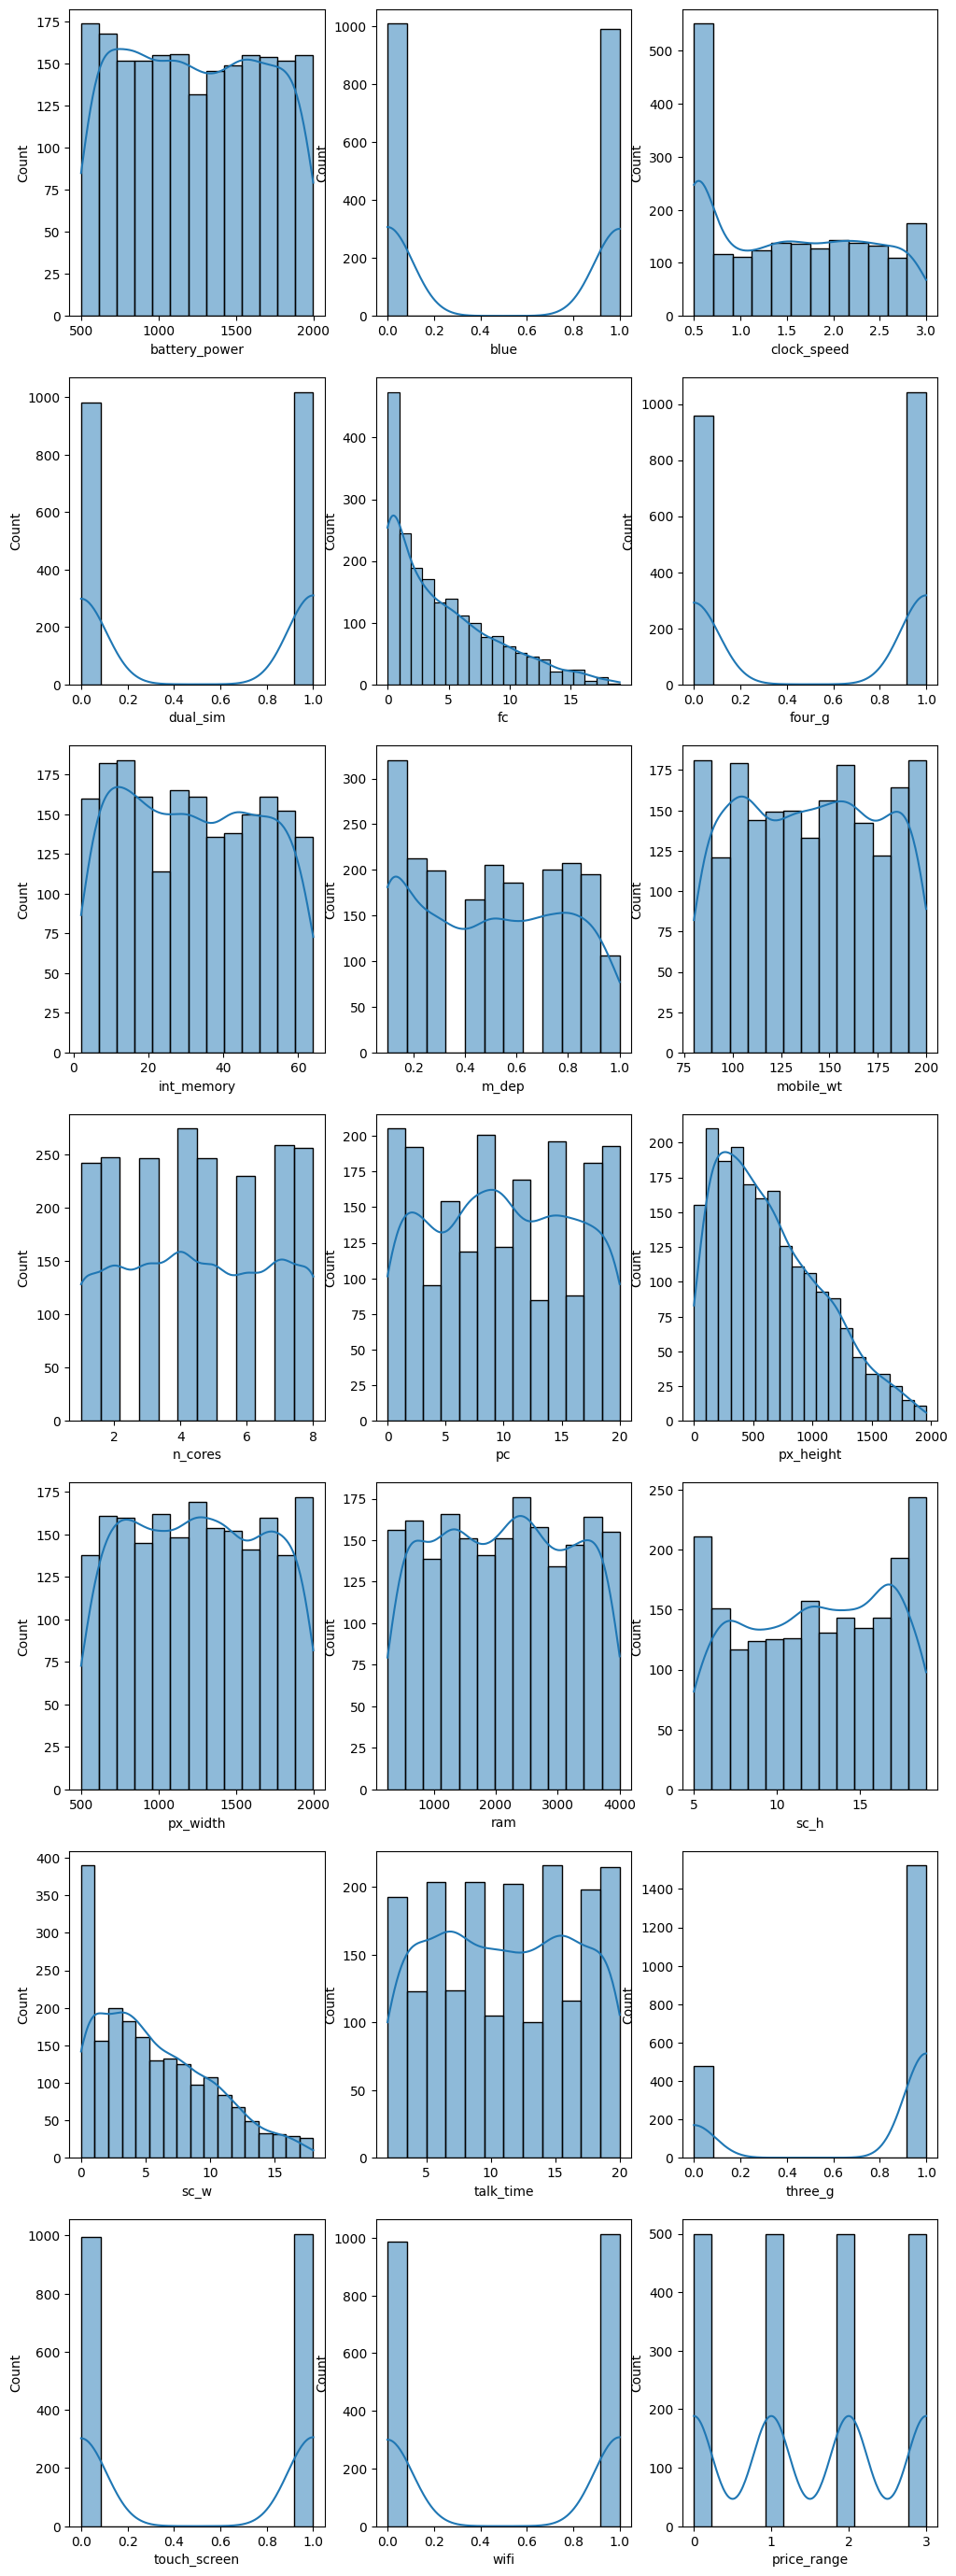

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 35))

for i in range(1, len(df.columns) + 1):
    plt.subplot(7, 3, i)
    sns.histplot(df[df.columns[i - 1]], kde=True)

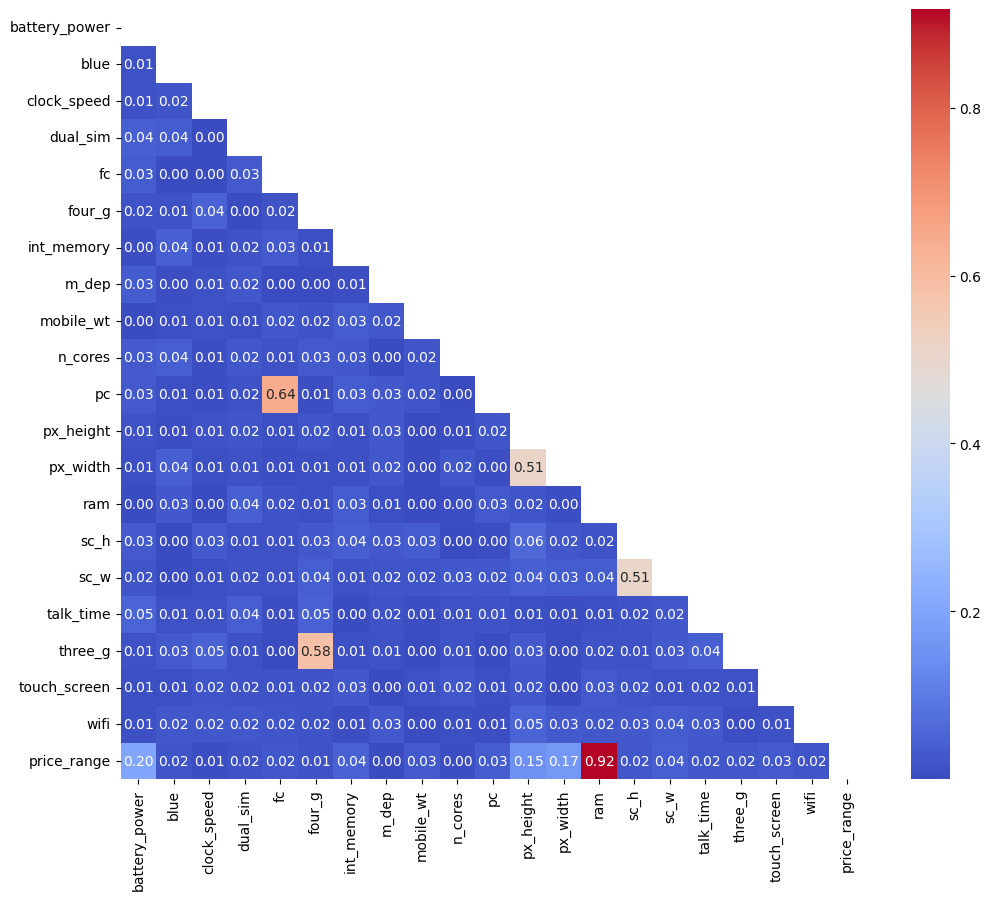

In [4]:
corr_df_encoded = df.corr()
plt.figure(figsize=(12, 10))
mask = np.zeros_like(corr_df_encoded, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df_encoded.abs(), cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.show()

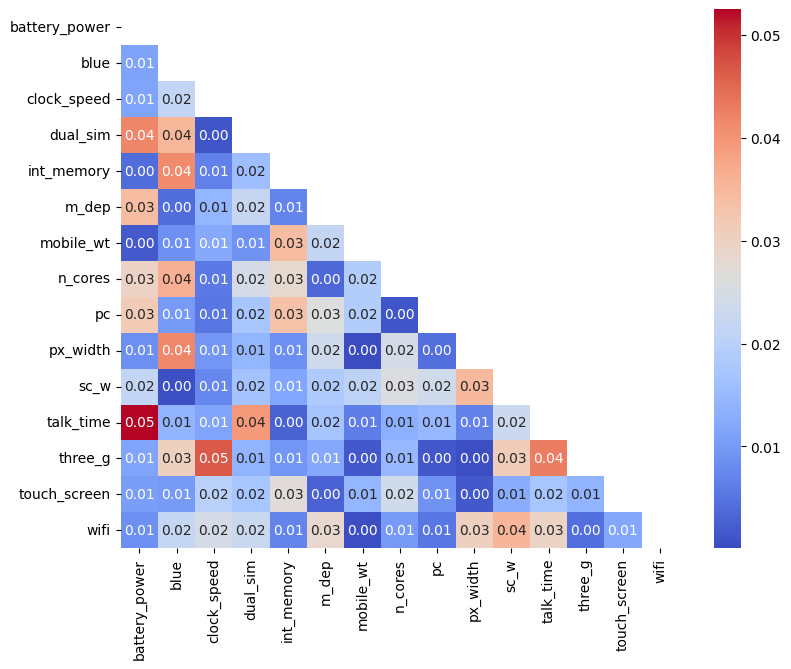

In [5]:
corr_df_encoded = df.corr()
plt.figure(figsize=(9, 7))
df_filtered = df.drop(['price_range', 'ram', 'fc', 'four_g', 'sc_h', 'px_height'], axis=1)
corr_df_encoded = df_filtered.corr()
mask = np.zeros_like(corr_df_encoded, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df_encoded.abs(), cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.show()

In [6]:
#Första körningen, innan justerande av features och hyperparametrar

from sklearn.model_selection import train_test_split, GridSearchCV

x = df.drop(['price_range'], axis=1)  # Features
y = df['price_range']  # Target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

print("Train data:", len(x_train))
print("Test data:", len(x_test))

Train data: 1600
Test data: 400


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#XGBoost och LightGBM är bättre vid stora dataset, så valde GradientBoosting istället. Behovet av optimal resurshantering är lägre i det här setet
model = GradientBoostingClassifier(random_state=2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Model accuracy with GradientBoosting 1: ", accuracy_score(y_pred, y_test))

Model accuracy with GradientBoosting 1:  0.9225


In [8]:
#Valde SVC för att det brukar vara en bra modell vid dataset med många features
model = SVC(C= 1, gamma= 0.1, kernel= 'rbf')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with SVC test 1: ", accuracy_score(y_pred, y_test))

Model accuracy with SVC test 1:  0.8425


In [9]:
#Valde RandomForest framför DecisionTree för att minska risken för overfitting, eftersom det är ett litet dataset
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with RandomForest 1: ", accuracy_score(y_pred, y_test))

Model accuracy with RandomForest 1:  0.895


In [10]:
#Andra körningen, justering av vilka features som ska vara med i testningen

x = df.drop(['price_range', 'ram', 'fc', 'four_g', 'sc_h', 'px_height'], axis=1)  # Droppar Features med mellanhöga till höga korrelationer
y = df['price_range']  # Target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

print("Train data:", len(x_train))
print("Test data:", len(x_test))

Train data: 1600
Test data: 400


In [11]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = GradientBoostingClassifier(random_state=2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Model accuracy with GradientBoosting test 2: ", accuracy_score(y_pred, y_test))

Model accuracy with GradientBoosting test 2:  0.3225


In [12]:
model = SVC(C= 1, gamma= 0.1, kernel= 'rbf')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with SVC test 2: ", accuracy_score(y_pred, y_test))

Model accuracy with SVC test 2:  0.3125


In [13]:
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with RandomForest 2: ", accuracy_score(y_pred, y_test))

Model accuracy with RandomForest 2:  0.31


In [14]:
#Körning med gridsearch för att få fram förslag på hyperparametrar

#GradientBoosting gridsearchCV
gbc = GradientBoostingClassifier(random_state=2)
param_grid = { #Valde att fokusera på dessa parametrar för att minska risken för overfitting
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
print("Bästa hyperparametrarna:", grid_search.best_params_)
print("Bästa modellens poäng:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Bästa hyperparametrarna: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Bästa modellens poäng: 0.33374999999999994


In [15]:
#SVC gridsearchCV
svc = SVC(random_state=2)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001]
}
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
print("Bästa hyperparametrarna:", grid_search.best_params_)
print("Bästa modellens poäng:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Bästa hyperparametrarna: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Bästa modellens poäng: 0.326875


In [16]:
#RandomForest gridsearchCV
rfc = RandomForestClassifier(random_state=2)
param_grid = { #Valde att fokusera på dessa parametrar för att minska risken för overfitting
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 5, 10]
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
print("Bästa hyperparametrarna:", grid_search.best_params_)
print("Bästa modellens poäng:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Bästa hyperparametrarna: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200}
Bästa modellens poäng: 0.33375000000000005


In [17]:
#Gridsearch verkar göra väldigt lite skillnad när så många features var droppade
#Testar att lägga tillbaka alla features utom RAM som hade en hög korrelation (0.92) med priset

x = df.drop(['price_range', 'ram'], axis=1)  # Droppade Features
y = df['price_range']  # Target 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

print("Train data:", len(x_train))
print("Test data:", len(x_test))

Train data: 1600
Test data: 400


In [18]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = GradientBoostingClassifier(learning_rate= 0.01,
                                   max_depth= 3, 
                                   n_estimators= 100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Model accuracy with GradientBoosting test 3: ", accuracy_score(y_pred, y_test))

Model accuracy with GradientBoosting test 3:  0.3


In [19]:
model = SVC(C= 10, #tar bort gamma från hyperpatametrarna eftersom gridsearch föreslog linear  
            kernel= 'linear')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with SVC test 3: ", accuracy_score(y_pred, y_test))

Model accuracy with SVC test 3:  0.31


In [20]:
model = RandomForestClassifier(n_estimators= 100,
                                max_depth= 4,
                                min_samples_leaf= 2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with RandomForest test 3: ", accuracy_score(y_pred, y_test))

Model accuracy with RandomForest test 3:  0.2975


In [21]:
#Att ta bort alla features förutom RAM gjorde ingen egentlig skillnad på accuracy.
#Utan RAM som en feature så blir accuracy ca 30% med alla tre modellerna.

In [22]:
#Fjärde körningen,

x = df.drop(['price_range', 'fc', 'four_g', 'sc_h', 'px_height'], axis=1)  # Droppade Features
y = df['price_range']  # Target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

print("Train data:", len(x_train))
print("Test data:", len(x_test))

Train data: 1600
Test data: 400


In [23]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = GradientBoostingClassifier(learning_rate= 0.01,
                                   max_depth= 3, 
                                   n_estimators= 100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Model accuracy with GradientBoosting test 4: ", accuracy_score(y_pred, y_test))

Model accuracy with GradientBoosting test 4:  0.825


In [24]:
model = SVC(C= 10,  
            kernel= 'linear')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with SVC test 4: ", accuracy_score(y_pred, y_test))

Model accuracy with SVC test 4:  0.905


In [25]:
model = RandomForestClassifier(n_estimators= 100,
                                max_depth= 4,
                                min_samples_leaf= 2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy with RandomForest test 4: ", accuracy_score(y_pred, y_test))

Model accuracy with RandomForest test 4:  0.81


In [26]:
#När RAM läggs tillbaka bland features med uppdaterade hyperparametrar så stiger accuracy igen,
#men blir lägre än accuracy i körning 1
#Det är iofs några features droppade i körning 4, så det påverkar antagligen accuracyn.
#Möjligt alternativ är också att det större overfitting i körning 1 jämfört med körning 4 pga valet av hyperparametrar.

#Nästa steg skulle vara att börja kolla lite nogare på hur de olika features är uppdelade för att se om det skulle behöva
#göras några ändringar i normalisering eller grupperingar.
#StandardScaler används dock redan.
#Och price_range är indelad i fyra jämnstora grupper.

In [27]:
min_price = df['price_range'].min()
max_price = df['price_range'].max()
print('min_price: ', min_price)
print('max_price: ', max_price)
#min_price = df[''].min()
#max_price = df[''].max()

min_price:  0
max_price:  3
